# Klasifikacija prirodnih nepogode
___
<br>

Za realizaciju ovoga projekta, korišten je skup podataka - [disaster dataset](https://www.kaggle.com/datasets/sarthaktandulje/disaster-damage-5class). Ovaj skup podataka sadrži slike prirodnih nepogoda:
- požar
- dim(mogući požar)
- poplava
- klizište

Također, skup sadrži i slike na kojima nisu prikazane navedene nepogode.

### 1. Uvoz skupa podataka

In [2]:
from glob import glob

### 1.1 Struktura skupa podataka

In [3]:
from tabulate import tabulate

directories = glob('disaster_dataset/*')

dataset_structure = [[x, len(glob(x + '/*'))] for x in directories]

print(tabulate([[x, len(glob(x + '/*'))] for x in directories], headers=['Direktorij', 'Broj slika'], tablefmt="grid"))

print(f'\nUkupan broj slika: {sum([len(glob(x + "/*")) for x in directories])}')

+----------------------------+--------------+
| Direktorij                 |   Broj slika |
+============================+==============+
| disaster_dataset\fire      |         2537 |
+----------------------------+--------------+
| disaster_dataset\flood     |         2706 |
+----------------------------+--------------+
| disaster_dataset\landslide |          310 |
+----------------------------+--------------+
| disaster_dataset\normal    |         2226 |
+----------------------------+--------------+
| disaster_dataset\smoke     |          302 |
+----------------------------+--------------+

Ukupan broj slika: 8081


### 1.2 Odabir uzorka

Zbog velike neuravnoteženosti skupa podataka, moglo bi doći do pristranosti modela klasama `normal`, `fire` i `flood`. Primjerice, skup slika klase `flood` je oko 9 puta veći od skupova klasa `smoke` i `landslide`.

Metode kojima se ovakav tip problema redovito rješava su:

<br>

| Metoda | Opis |
| :--- | :--- |
| **Ponderiranje klasa (Class Weighting)** | Dodjeljuju se veće težine (weights) manjinskim klasama <br><br> (Dim: 302, Klizište: 310) u funkciji gubitka (loss function). <br><br> To prisiljava model da pridaje veću važnost **ispravnom** klasificiranju tih rjeđih primjera. <br><br> Ovo je često najjednostavniji i najučinkovitiji pristup. |
| **Oversampling** | **Povećavanje** broja primjera u manjinskim klasama <br><br>(npr. tehnikama poput **SMOTE** ili jednostavno ponavljanjem postojećih slika) <br><br>kako bi se izjednačio broj s dominantnim klasama. |
| **Undersampling** | **Smanjivanje** broja primjera u dominantnim klasama <br><br>(Požar: 2537, Poplava: 2706) nasumičnim uklanjanjem slika. <br><br>**Oprez:** Gubitak potencijalno važnih informacija je rizik. |
| **Augmentacija podataka (Data Augmentation)** | Stvaranje novih primjera iz postojećih manjinskih slika primjenom transformacija <br><br>(npr. rotacija, zrcaljenje, izrezivanje, promjena svjetline) <br><br>kako bi se umjetno povećao njihov broj i raznolikost. |

<br>

Za potrebe ovoga projekta, iskoristit će se metoda undersamplinga kako bi se smanjila iskorištenost računalnih resursa i skratilo vrijeme učenja modela.
To znači da će skupovi `smoke` i `landslide` ostati gotovo isti, a iz klasa `fire`, `flood` i `normal` će se uzeti nasumično odabrani uzorak koji će biti blizu broja podataka u najmanjem skupu.

<br>

Kako je klasa `smoke`, klasa koja ima najmanje podataka (302), zaokružit ćemo taj broj, te uzeti slučajni uzorak od 300 slika iz svake klase.

In [4]:
import numpy as np

In [5]:
np.random.seed(9)

fire_sample = np.random.choice(glob(directories[0] + '/*.jpg'), 300, replace=False)
flood_sample = np.random.choice(glob(directories[1] + '/*.jpg'), 300, replace=False)
normal_sample = np.random.choice(glob(directories[2] + '/*.jpg'), 300, replace=False)
smoke_sample = np.random.choice(glob(directories[3] + '/*.jpg'), 300, replace=False)
landslide_sample = np.random.choice(glob(directories[4] + '/*.jpg'), 300, replace=False)

In [6]:
from sklearn.model_selection import train_test_split

all_paths = np.concatenate([
    fire_sample,
    flood_sample,
    normal_sample,
    smoke_sample,
    landslide_sample
])
# 0=fire, 1=flood, 2=normal, 3=smoke, 4=landslide (primjer)
labels = np.array(
    [0] * 300 +
    [1] * 300 +
    [2] * 300 +
    [3] * 300 +
    [4] * 300
)


In [7]:
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, labels, test_size=0.3, random_state=9, stratify=labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=9, stratify=y_temp
)

print(f"Trening skup (70%): {len(X_train_paths)} slika") # 1050
print(f"Validacija skup (15%): {len(X_val_paths)} slika") # 225
print(f"Test skup (15%): {len(X_test_paths)} slika") # 225

Trening skup (70%): 1050 slika
Validacija skup (15%): 225 slika
Test skup (15%): 225 slika


In [8]:
import cv2
import tensorflow as tf

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=5, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.image_paths[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]

        X = np.empty((self.batch_size, *self.target_size, 3), dtype=np.float32)

        for i, path in enumerate(batch_paths):

            img_cv2 = cv2.imread(path)

            if img_cv2 is None:
                print(f"Upozorenje: OpenCV nije uspio učitati sliku na lokalnom disku: {path}")
                continue

            # Konverzija iz BGR (OpenCV standard) u RGB (Keras/TensorFlow standard)
            img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

            img_resized = cv2.resize(img_rgb, self.target_size)

            img_array = img_resized.astype('float32') / 255.0

            X[i,] = img_array

        # One-hot encoding
        y = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)


BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_generator = CustomDataGenerator(X_train_paths, y_train, BATCH_SIZE, TARGET_SIZE, shuffle=True)
validation_generator = CustomDataGenerator(X_val_paths, y_val, BATCH_SIZE, TARGET_SIZE, shuffle=False)
test_generator = CustomDataGenerator(X_test_paths, y_test, BATCH_SIZE, TARGET_SIZE, shuffle=False)

In [9]:
import tensorflow as tf

NUM_CLASSES = 5

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False, # Ne uključujemo originalne klasifikacijske slojeve
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:

NUM_EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator
)

c:\Users\nikol\Desktop\disaster-classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.4854 - loss: 1.2978 - val_accuracy: 0.7232 - val_loss: 0.7809
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.7520 - loss: 0.6863 - val_accuracy: 0.7411 - val_loss: 0.7815
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.8340 - loss: 0.5136 - val_accuracy: 0.8125 - val_loss: 0.5804
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.8965 - loss: 0.3462 - val_accuracy: 0.7991 - val_loss: 0.5925
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.9141 - loss: 0.2585 - val_accuracy: 0.8170 - val_loss: 0.5580
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.9307 - loss: 0.2180 - val_accuracy: 0.8080 - val_loss: 0.5755
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.9590 - loss: 0.1661 - val_accuracy: 0.8080 - val_loss: 0.5671
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.9736 - loss: 0.1395 - val_accuracy: 0.7991 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8348 - loss: 0.4711
Testna točnost: 83.48%
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step

--- Classification Report ---
              precision    recall  f1-score   support

        fire       0.79      0.93      0.86        45
       flood       0.94      0.71      0.81        45
      normal       0.86      0.80      0.83        45
       smoke       0.71      0.84      0.77        44
   landslide       0.93      0.89      0.91        45

    accuracy                           0.83       224
   macro avg       0.85      0.83      0.83       224
weighted avg       0.85      0.83      0.84       224



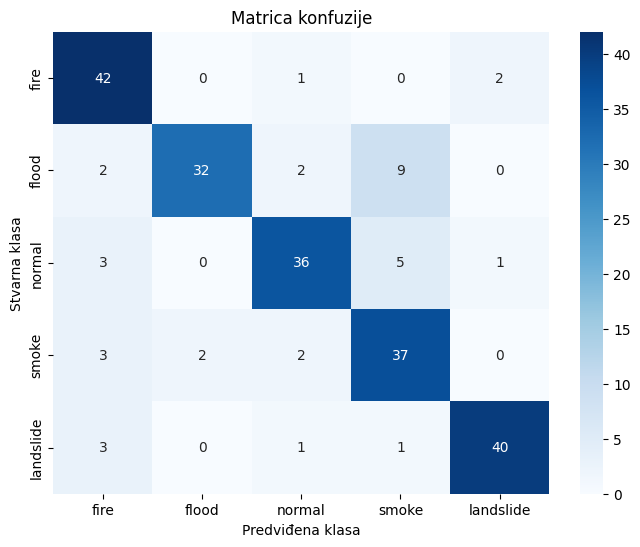

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy = model.evaluate(test_generator)
print(f"Testna točnost: {accuracy*100:.2f}%")

y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true_one_hot = []
for i in range(len(test_generator)):
    _, batch_y = test_generator[i]
    y_true_one_hot.extend(batch_y)
y_true = np.argmax(y_true_one_hot, axis=1)


target_names = ['fire', 'flood', 'normal', 'smoke', 'landslide']
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrica konfuzije')
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()